In [1]:
%run Function_Master.ipynb
%run Parameterization.ipynb

# Testing Individual Solution

In [2]:
%store -r sol

In [3]:
dfs = svs(sol, param)

In [4]:
# Example: P_I dataframe
dfs = svs(sol, param)

## Plotting individual or combined sources and sinks for given state variable

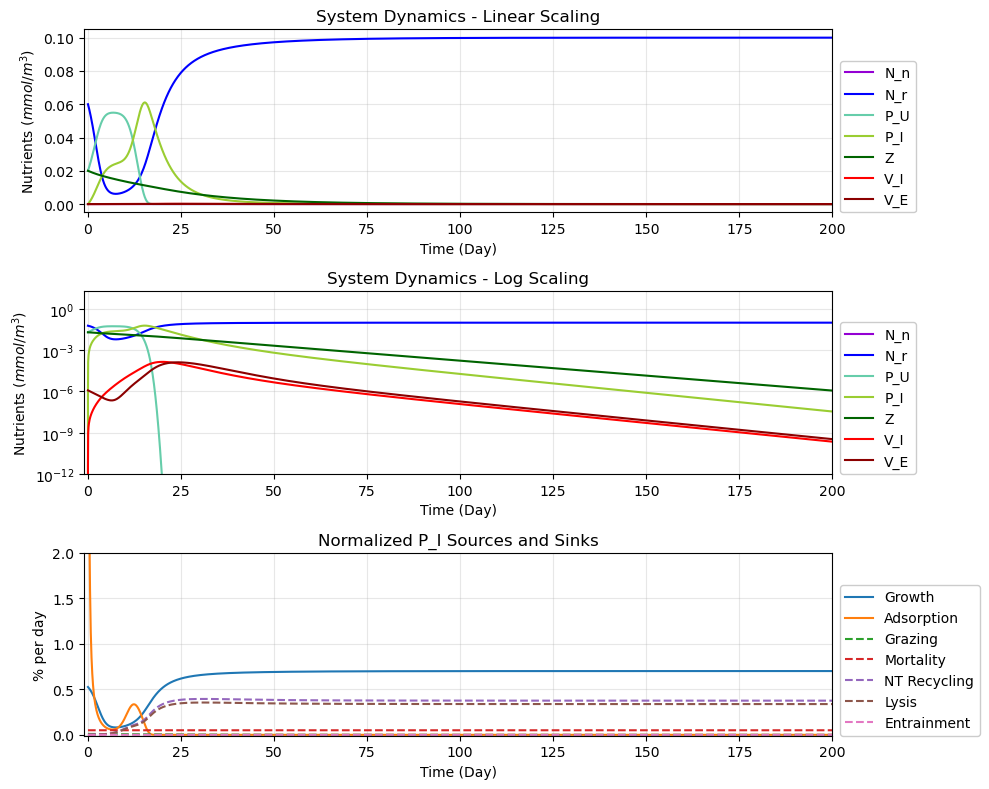

In [5]:
""" Plotting SVS for specified state """

fig, axs = plt.subplots(3, 1, figsize = (10, 8))

labels = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']
colors = ["darkviolet", "blue", "mediumaquamarine", "yellowgreen", "darkgreen", "red", "darkred"]

# Plotting states evolution
for i, df in enumerate(dfs):
    axs[0].plot(df["Time (Days)"], df[labels[i]], color=colors[i], label=labels[i])
    axs[1].plot(df["Time (Days)"], df[labels[i]], color=colors[i], label=labels[i])
    
""" assign index to 'state' accourding to label order """
state = 3
time_span = dfs[state]["Time (Days)"]

# Combined Sources and Sinks
# axs[2].plot(time_span, dfs[state]["Sources"] / dfs[state][labels[state]], color='black', label="Sources")
# axs[2].plot(time_span, dfs[state]["Sinks"] / dfs[state][labels[state]], '--', color='black', label="Sinks")
    
# Individual transfer terms
for column in dfs[state].columns[2:-3]:
    if '--' in column: 
        axs[2].plot(time_span, dfs[state][column] / dfs[state][labels[state]], '--', label=column[:-3])
    else: 
        axs[2].plot(time_span, dfs[state][column] / dfs[state][labels[state]], label=column)
    
# Axs specific settings
axs[0].set_title("System Dynamics - Linear Scaling")
axs[0].set_ylabel(r'Nutrients ($mmol/m^3$)')

axs[1].set_title("System Dynamics - Log Scaling")
axs[1].set_ylabel(r'Nutrients ($mmol/m^3$)')
axs[1].set_yscale('log')
axs[1].set_ylim(1e-12, 20)

axs[2].set_title(f"Normalized {labels[state]} Sources and Sinks")
axs[2].set_ylabel('% per day')
axs[2].set_ylim(-.01, 2)

# Broad Axs settings   
for ax in axs:
    ax.set_xlabel('Time (Day)')
    ax.set_xlim(-1, 200)
    ax.grid(which='both', alpha=.3)
    ax.legend(loc=(1.01, 0), framealpha=1)
    
plt.tight_layout()
plt.show()

# Pulling Large Solution Set

In [8]:
%store -r sols

In [2]:
%store -r NPZ_sols NPZV_sols

## Sorting by ss or osc if needed

In [7]:
# Filtering solutions into different groups

# ss_sols = []
# osc_sols = []

# for z0, sol in sols: 
#     info = ss_or_osc(sol)
    
#     if info == 'osc':
#         osc_sols.append([z0, sol])
        
#     else:
#         ss_sols.append([z0, sol] + list(info))
        
# print(f'Out of {len(sols)} solutions, {len(ss_sols)} are steady (or decay) and {len(osc_sols)} are oscillatory.')

## Creating DataFrames

In [10]:
'''Creating a data frame for each state variable that holds the 
values of each transfer term at the end of the solution time span.

The values are normalized later when plotted.'''

rate_dfs = [pd.DataFrame()] * 7

for z0, sol in NPZV_sols:
    
    dfs = svs(sol, param)
    
    for i, df in enumerate(dfs):
        last_row = df.tail(1)
        last_row.insert(0, 'Total N', sum(z0), True)

        rate_dfs[i] = pd.concat([rate_dfs[i], last_row], ignore_index=True)

# Drop unecessary columns (Time (days), sources, sinks, dSdt) 

for df in rate_dfs:
    df.drop(df.columns[[1, -1, -2, -3]], axis=1, inplace=True)

In [11]:
rate_dfs[3].div(rate_dfs[3]['P_I'], axis=0).tail()

,Total N,P_I,Growth,Adsorption,Grazing --,Mortality --,NT Recycling --,Lysis --,Entrainment --
1995,13.093904,1.0,1.391063,0.0,1.243011,0.05,0.051606,0.046446,0.0
1996,13.168777,1.0,1.391127,0.0,1.243097,0.05,0.051595,0.046435,0.0
1997,13.244084,1.0,1.391190,0.0,1.243182,0.05,0.051583,0.046425,0.0
1998,13.319829,1.0,1.391253,0.0,1.243266,0.05,0.051572,0.046415,0.0
1999,13.396013,1.0,1.391315,0.0,1.243350,0.05,0.051561,0.046405,0.0


In [13]:
(1.3411-1.2433)

0.09779999999999989

## Defining colors for plotting rates

In [5]:
term_colors = {}

for df in rate_dfs:
    
    for col in df.columns:
        if '--' in col:
            col = col[:-3]
            
        if col not in term_colors.keys():
            term_colors[col] = ''

remove = ('Total N', 'N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E')

for key in remove:
    term_colors.pop(key, None)

colors = ['darkred', 'r', 'orangered', 'sienna', 'darkorange', 
          'goldenrod', 'olive', 'darkgreen', 'mediumaquamarine', 'teal', 
          'steelblue', 'darkblue', 'b', 'blueviolet', 'purple']

for i, key in enumerate(term_colors.keys()):
    term_colors[key] = colors[i]

## Plotting Normalized SVS

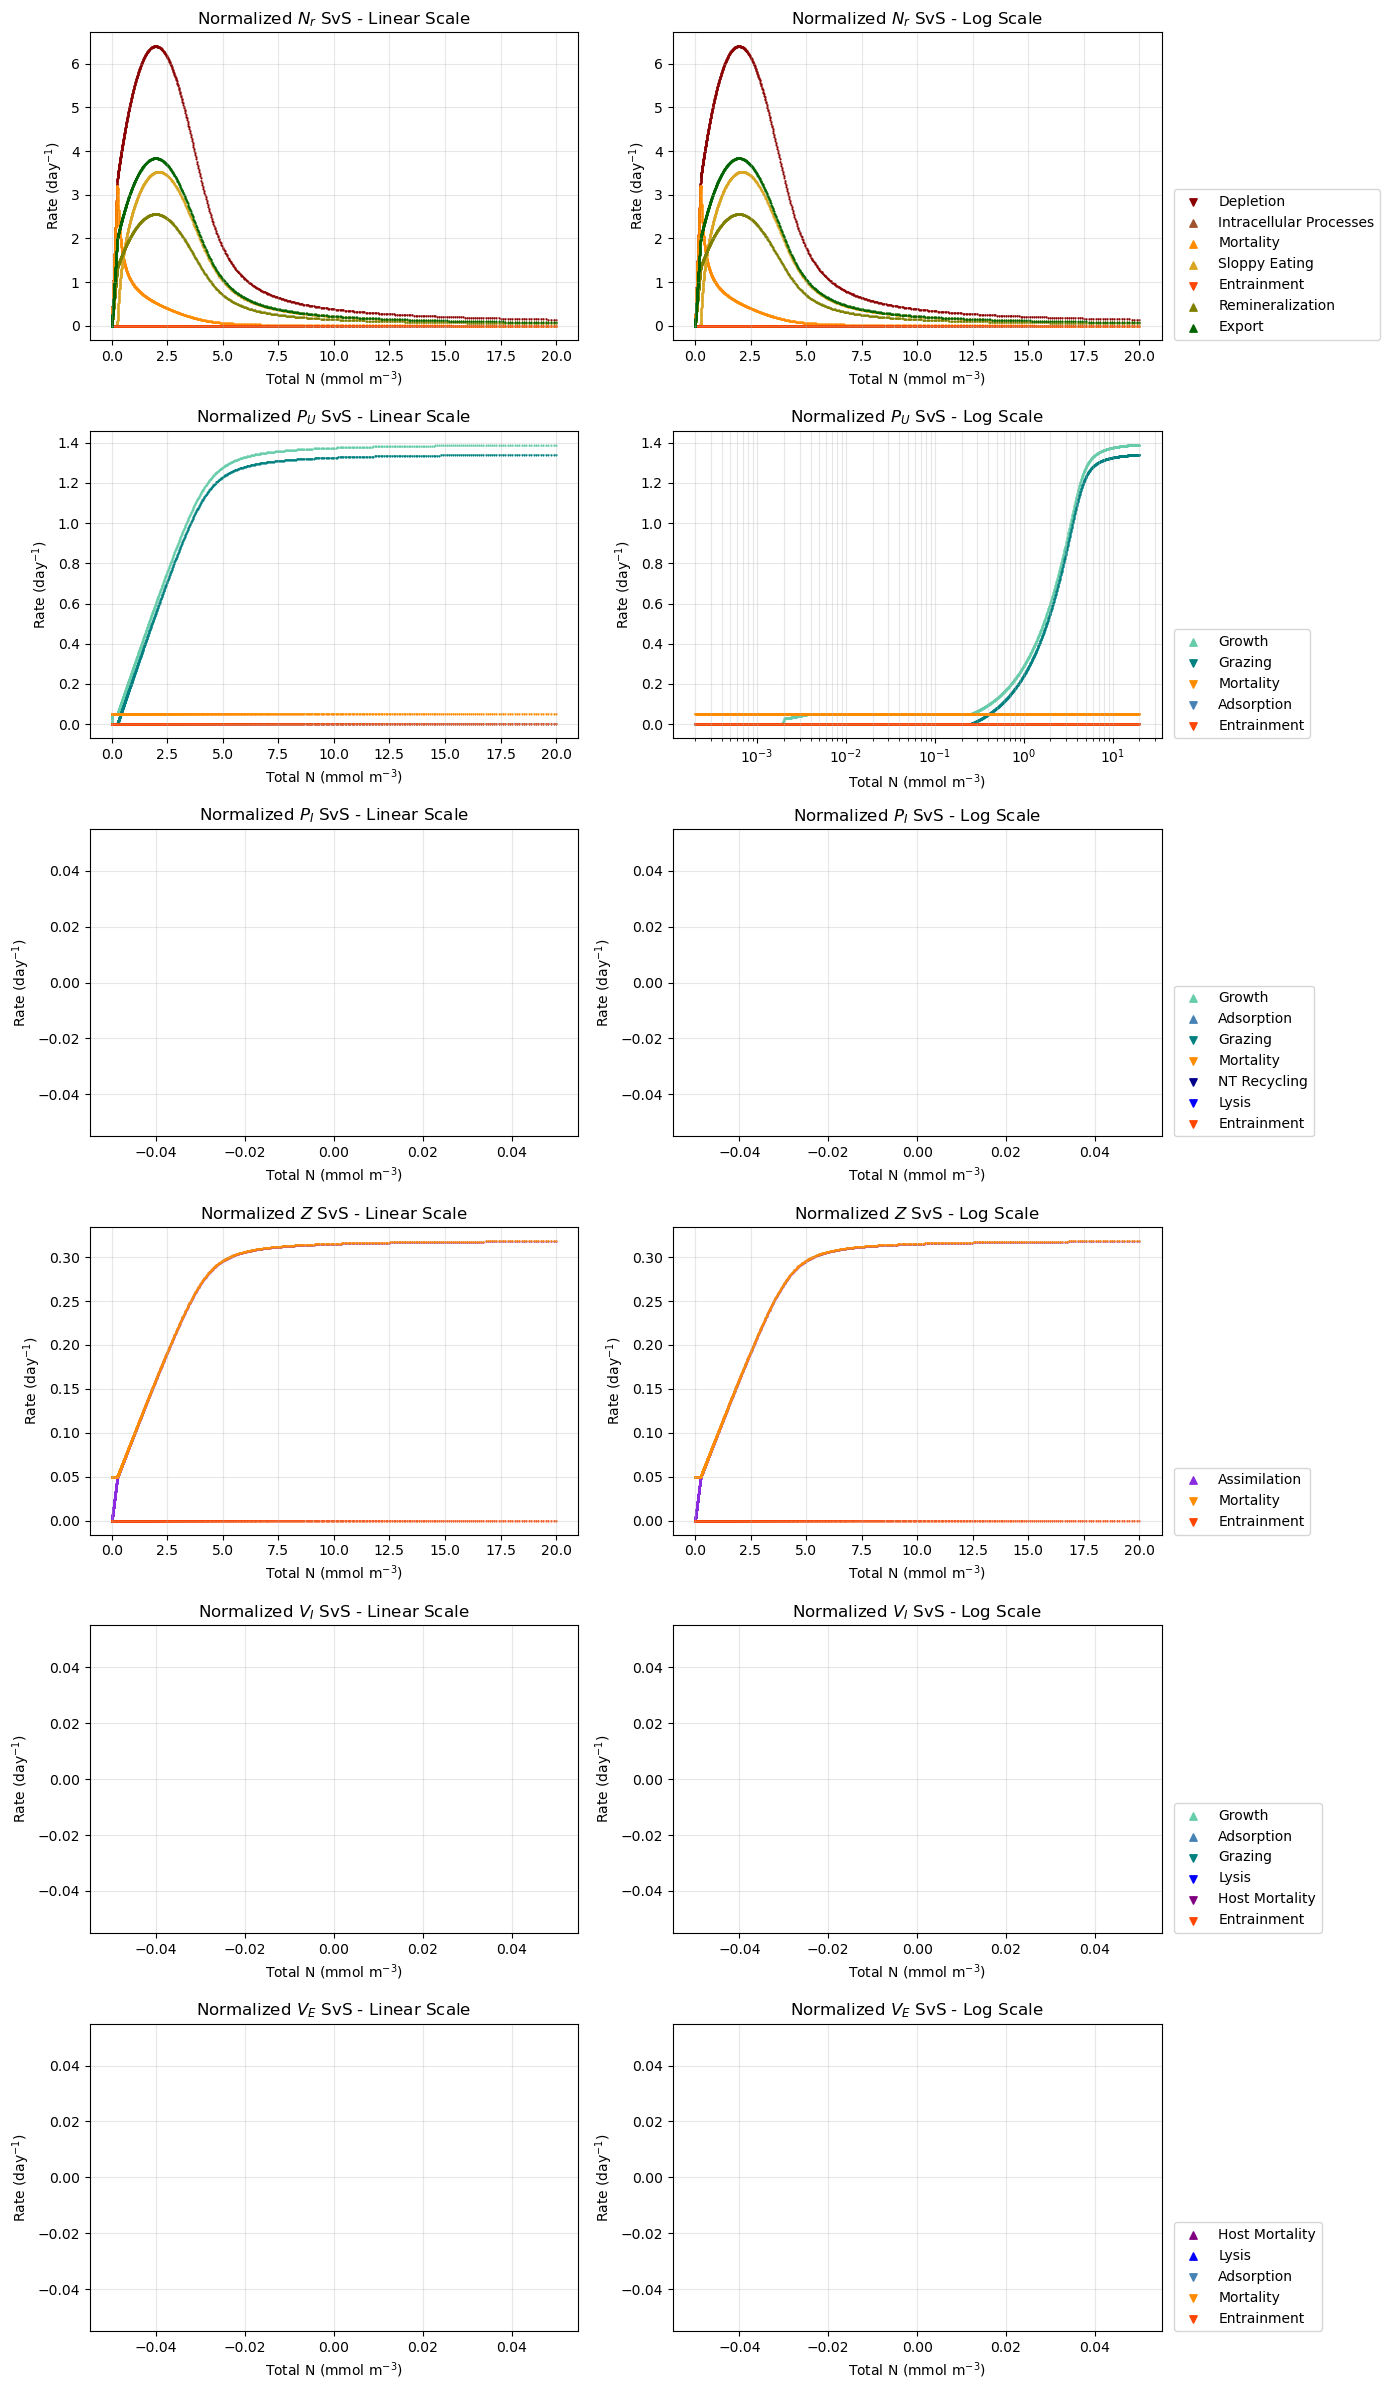

In [6]:
fig, axs = plt.subplots(6, 2, figsize=(14, 24))

labels = ['N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']

# Loop through state rate dfs
for i, df in enumerate(rate_dfs[1:]):

    for column in df.columns[2:]:
    
        if '--' in column: 
            axs[i][0].scatter(df['Total N'], df[column] / df.iloc[:, 1], marker='v', s=.5, color=term_colors[column[:-3]], label=column[:-3])
            axs[i][1].scatter(df['Total N'], df[column] / df.iloc[:, 1], marker='v', s=.5, color=term_colors[column[:-3]], label=column[:-3])
            
            # axs[i][0].plot(df['Total N'], df[column] / df.iloc[:, 1], '--', color=term_colors[column[:-3]], label=column[:-3])
            # axs[i][1].plot(df['Total N'], df[column] / df.iloc[:, 1], '--', color=term_colors[column[:-3]], label=column[:-3])
        else: 
            axs[i][0].scatter(df['Total N'], df[column] / df.iloc[:, 1], marker='^', s=.5, color=term_colors[column], label=column)
            axs[i][1].scatter(df['Total N'], df[column] / df.iloc[:, 1], marker='^', s=.5, color=term_colors[column], label=column)
            
            # axs[i][0].plot(df['Total N'], df[column] / df.iloc[:, 1], color=term_colors[column], label=column)
            # axs[i][1].plot(df['Total N'], df[column] / df.iloc[:, 1], color=term_colors[column], label=column)
            
    
    axs[i][0].set_title(fr'Normalized ${labels[i]}$ SvS - Linear Scale')
    # axs[i][0].set_xlim(-1, 21)
    
    axs[i][1].set_title(fr'Normalized ${labels[i]}$ SvS - Log Scale')
    # axs[i][1].set_xscale('log')
    # axs[i][1].set_xlim(1e-4, 4e1)
    axs[i][1].legend(markerscale=7.5, loc=(1.025, 0))
    
# Tuning Pu limits  
# axs[1][0].set_ylim(-.01, .2)
# axs[1][1].set_ylim(-.01, .2)
axs[1][1].set_xscale('log')

axs = axs.reshape(-1)

for ax in axs:
    ax.grid(which='both', alpha=.3)

    ax.set_ylabel(r'Rate (day$^{-1}$)')
    ax.set_xlabel(r'Total N (mmol m$^{-3}$)')

plt.tight_layout()
plt.show()